In [679]:
import math

import pandas as pd
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as plticker
import seaborn as sns

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

2/16/19 - WORK IN PROGRESS for Stormwater Conference Presentation.

Looking at 2009 to 2018 CSO (combined sewer overflow) flow to determine a pattern. Right away the biggest issue is a lack of data - I will try and get more data from previous years. As of now this is just to test the python libraries and to visual flow in different ways.

1) Examining Total Flow

For this the flow was divided into 3 segments: discharge values >= 1e7 gallons, discharge values < 1e7 and >= 1e6 gallons, and discharge values < 1e6 gallons.

2) Examining flow per CSO - not done

3) Trying to tie all CSO flows together - not done

# Examining Total CSO Flow

In [556]:
work_book = r'C:\Users\Kerling\Documents\JupyterNotebooks\CSO_10_Years.xlsx'

df = pd.read_excel(open(work_book,'rb'), sheet_name=0)  # create a dataframe containing all flow

discharge, inches, intensity = ['Discharge','Inches','Intensity']
date = 'Date'
df.columns.values[0] = date  # renaming first column to a variable
df.columns.values[-3:] = [discharge, inches, intensity]  # renaming last 3 columns to variables, for ease of use later on

discharge_df = df[[date,discharge, inches, intensity]]  # create a dataframe for just discharge, inches of rain, and intensity of rain
#discharge_df.dropna()  # dropping rows with zero discharge - scratch that, did it in the spreadsheet
discharge_df = discharge_df.sort_values([date])
discharge_df['Prediction'] = None

Discharge_df contains columns for discharge (gal), inches, and intensity. The first 10 columns can be shown to demonstrate the data.

In [557]:
discharge_df.head(10)

,Date,Discharge,Inches,Intensity,Prediction
0,2009-02-12,5690000.0,0.47,0.18,None
1,2009-02-19,7004000.0,1.15,0.18,None
2,2009-02-22,586000.0,0.60,0.12,None
3,2009-02-27,3932000.0,0.80,0.22,None
4,2009-02-28,1714000.0,0.60,0.12,None
5,2009-03-08,6687000.0,0.35,0.14,None
6,2009-03-11,9863000.0,0.80,0.22,None
7,2009-03-29,5702000.0,0.80,0.18,None
8,2009-03-30,184000.0,0.10,0.03,None
9,2009-04-03,4111000.0,0.85,0.25,None


______

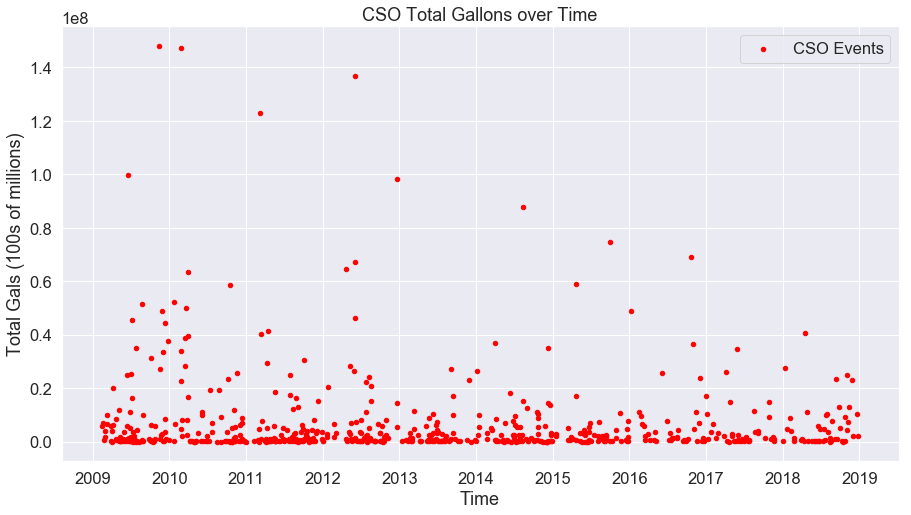

In [680]:
dates_more = pd.to_datetime(discharge_df[date])

fig,ax = plt.subplots()
ax.set(xlabel=xlabel, ylabel='Total Gals (100s of millions)',
           title='CSO Total Gallons over Time')

plt.scatter(dates_more, discharge_df[discharge], s =20, c = 'red', label = 'CSO Events')
ax.legend()
ax.grid(True)
plt.show()

Above: The Total Discharge per CSO event plotted vs Time. The total amount of discharges > 20 million gallons has been decreasing year after year. In the past when in heavy rainstorms everything would overflow, and the totals would be in the hundreds of millions per storm. Cresting a billion gallons of total CSO flow in some years. Plotting with a linear scale does not give a great idea of the actual spread though, since a few outliers in the billions drag the y-axis into the hundreds of millions.


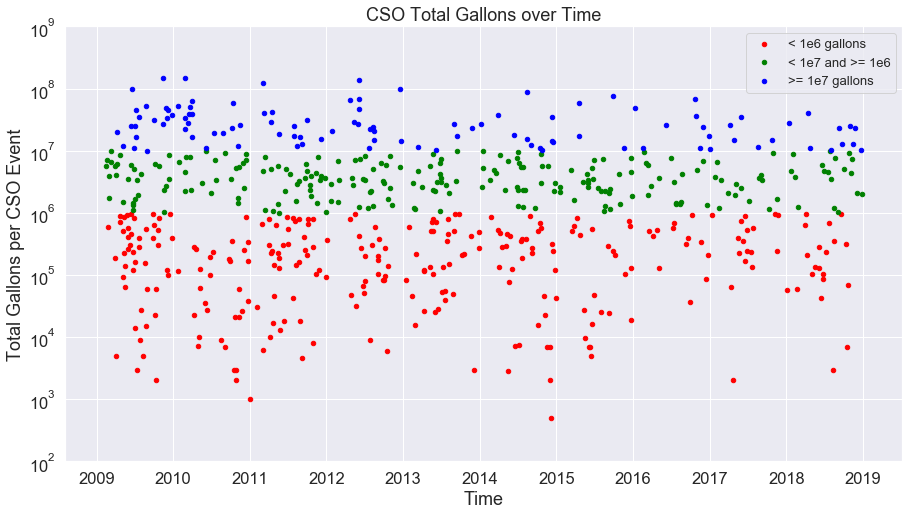

In [775]:
# flow < 1e6
discharge_df_less_1e6 = discharge_df[discharge_df[discharge] < 1e6]

# flow < 1e7 and >= 1e6
discharge_df_1e6 = discharge_df[discharge_df[discharge] < 1e7]
discharge_df_1e6 = discharge_df_1e6[discharge_df_1e6[discharge] >= 1e6]

# flow <= 1e5
discharge_df_more_1e7 = discharge_df[discharge_df[discharge] >= 1e7]

#converting dates
dates_less = pd.to_datetime(discharge_df_less_1e6[date])
dates_1e6 = pd.to_datetime(discharge_df_1e6[date])
dates_more = pd.to_datetime(discharge_df_more_1e7[date])

fig,ax = plt.subplots()
ax.set(xlabel=xlabel, ylabel='Total Gallons per CSO Event',
           title='CSO Total Gallons over Time')

plt.scatter(dates_less, discharge_df_less_1e6[discharge], s =20, c = 'red', label = '< 1e6 gallons')
plt.scatter(dates_1e6, discharge_df_1e6[discharge], s =20, c = 'green', label = '< 1e7 and >= 1e6')
plt.scatter(dates_more, discharge_df_more_1e7[discharge], s =20, c = 'blue', label = '>= 1e7 gallons')
ax.legend(fontsize=13)
ax.grid(True)
plt.ylim(1e2, 1e9)
plt.yscale('log')
plt.show()

Above: The y-axis can be set to a log scale to better understand the spread of data. Further understanding can be gained by colorizing the data based on order of magnitude. Here the values < 1e6 gallons are red, values < 1e7 and >= 1e6 are green, and values >= 1e7 are blue. These become the breaks to further analyze for patterns based on the inches of rain and intensity of rain. A fourth analysis on the total dataset will be run as well.

Below: The different order of magnitude breaks can be further summarized by finding the mean rainfall inches and intensity, and the most common inches and intensity values per each discharge magnitude break.

In [776]:
print('Mean rainfall in inches and mean intensity for discharge events < 1e6:',
      round(discharge_df_less_1e6[inches].mean(),2),
      'in |', round(discharge_df_less_1e6[intensity].mean(),2), 'in/hr')
print('Most common rainfall inches and intensity values for discharge events < 1e6:',
      round(discharge_df_less_1e6[inches].value_counts().idxmax(),2), 'in |', 
      round(discharge_df_less_1e6[intensity].value_counts().idxmax(),2), 'in/hr')
print()
print('Mean rainfall in inches and mean intensity for discharge events < 1e7 and >= 1e6:',
      round(discharge_df_1e6[inches].mean(),2), 'in |',
      round(discharge_df_1e6[intensity].mean(),2), 'in/hr')
print('Most common rainfall inches and intensity values for discharge events < 1e7 and >= 1e6:',
      round(discharge_df_1e6[inches].value_counts().idxmax(),2), 'in |',
      round(discharge_df_1e6[intensity].value_counts().idxmax(),2), 'in/hr')
print()
print('Mean rainfall in inches and mean intensity for discharge events >= 1e7:',
      round(discharge_df_more_1e7[inches].mean(),2), 'in |',
      round(discharge_df_more_1e7[intensity].mean(),2), 'in/hr')
print('Most common rainfall inches and intensity values for discharge events >= 1e7:',
      round(discharge_df_more_1e7[inches].value_counts().idxmax(),2), 'in |',
      round(discharge_df_more_1e7[intensity].value_counts().idxmax(),2), 'in/hr')
print()
print('Mean rainfall in inches and mean intensity for all discharge events:',
      round(discharge_df[inches].mean(),2), 'in |',
      round(discharge_df[intensity].mean(),2), 'in/hr')
print('Most common rainfall inches and intensity values for all discharge events:',
      round(discharge_df[inches].value_counts().idxmax(),2), 'in |',
      round(discharge_df[intensity].value_counts().idxmax(),2), 'in/hr')

Mean rainfall in inches and mean intensity for discharge events < 1e6: 0.27 in | 0.11 in/hr
Most common rainfall inches and intensity values for discharge events < 1e6: 0.01 in | 0.1 in/hr

Mean rainfall in inches and mean intensity for discharge events < 1e7 and >= 1e6: 0.71 in | 0.24 in/hr
Most common rainfall inches and intensity values for discharge events < 1e7 and >= 1e6: 0.77 in | 0.22 in/hr

Mean rainfall in inches and mean intensity for discharge events >= 1e7: 1.9 in | 0.47 in/hr
Most common rainfall inches and intensity values for discharge events >= 1e7: 1.4 in | 0.34 in/hr

Mean rainfall in inches and mean intensity for all discharge events: 0.72 in | 0.22 in/hr
Most common rainfall inches and intensity values for all discharge events: 0.01 in | 0.01 in/hr


_______

_______

The goal is to determine if there is a way to forecast future CSO overflows to a reasonable degree. Or, barring that, at least fill in the gaps for when the CSO Meters must be removed for general maintenance. Given the nature of the data, it is assumed there are far more variables in play then just what is given in the spreadsheet. Sediment in the pipes, blockages, etc are all things that could impact the data at any one point in time. A more robust hydrological model would be needed to make a determination to a high degree of accuracy. 

The goal here is to be able to say to a reasonable degree that "with x amount of rain there will be a CSO within some range" could be helpful. Even if the specific CSO cannot be pinpointed, knowing that there will be a CSO event is handy. It is possible just hitting the same order of magnitude could be a positive.

Plotting the order of magnitue vs the percent of the total events:

values > = 1e7 account for ~18% of the total events <br>
values <1e7 and  >= 1e6 account for ~66% of the total events <br>
values <= 1e5 account for ~16% of the total events
all values account for 100% of the total events (obviously)

Next steps are to plot discharge within each break against inches and intensity, separately, to look for patterns. <br>
Then a regression using both inches and intensity will attempt to more accurately predict the flow.

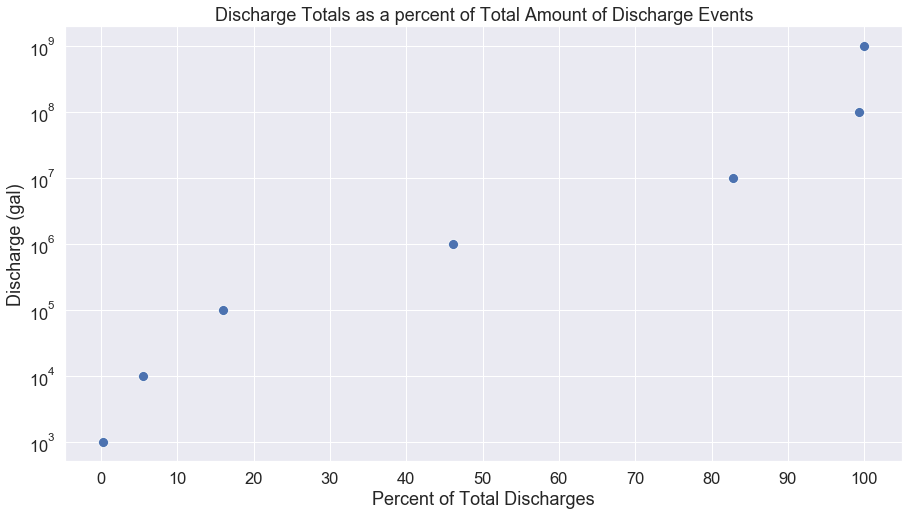

In [581]:
perc = []
total = []

for i in range(3,10):  # creating lists for the percent and order of magnitude
    discharge_df_mag = discharge_df[discharge_df[discharge] <= 10**i]
    perc.append(round(discharge_df_mag[discharge].count()/discharge_df[discharge].count()*100,3))
    total.append(10**i)

sns.scatterplot(perc,total, s = 100).set_yscale('log')  # scatter plot with log scale

ax = plt.gca()
ax.set(xlabel = 'Percent of Total Discharges', ylabel= 'Discharge (gal)',
        title= 'Discharge Totals as a percent of Total Amount of Discharge Events')
ax.grid(True)

loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.show()

_____

In [762]:
def abline(slope, intercept, rsquared):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    if rs >= 0.09:
        plt.plot(x_vals, y_vals, '--', c = 'black', label = "Slope with r^2 of %s" % rsquared)
    else:
        plt.plot(x_vals, y_vals, '--', c = 'black')
        

def graph_slope_rs(x, y, xlabel, ylabel, title, label, slope_on, log):
    """
    plotting points with a slope, legend, titles, etc. 
    Note to self: In the future just use Seaborn as it does this in a much easier fashion.
    
    """
    try:
        rs = round(np.corrcoef(x, y)[0,1]**2,2)  # computing the rsquared
    except TypeError:
        rs = 0
    
    fig,ax = plt.subplots()
    ax.set(xlabel = xlabel, ylabel= ylabel,
           title= title + ' - rsquared of ' + str(rs))
    ax.grid(True)
    
    slope, intercept = np.polyfit(x, y, 1)  # computing the slope and intercept

    plt.scatter(x,y, c ='red', label = label)
    if slope_on == True:
        abline(slope,intercept, rs)  # plotting slope line
    if log == True:
        plt.ylim(1e3,1e9)
        plt.yscale('log')
    ax.legend()
    plt.show()

_____

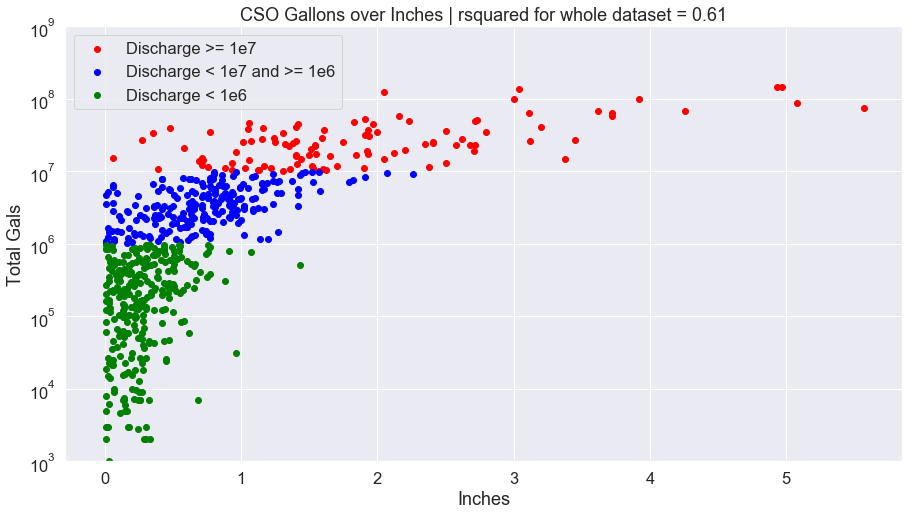

In [795]:
rs = round(np.corrcoef(discharge_df[inches], discharge_df[discharge])[0,1]**2,2)  # computing the rsquared

fig,ax = plt.subplots()
ax.set(xlabel = 'Inches', ylabel= 'Total Gals',
           title= 'CSO Gallons over Inches | rsquared for whole dataset = {}'.format(rs))
ax.grid(True)

plt.scatter(discharge_df_more_1e7[inches],discharge_df_more_1e7[discharge], c ='red', label = 'Discharge >= 1e7')
plt.scatter(discharge_df_1e6[inches],discharge_df_1e6[discharge], c ='blue', label = 'Discharge < 1e7 and >= 1e6')
plt.scatter(discharge_df_less_1e6[inches],discharge_df_less_1e6[discharge], c ='green', label = 'Discharge < 1e6')

plt.ylim(1e3,1e9)
plt.yscale('log')
ax.legend()
plt.show()

The total system discharge plotted against the inches of rain and intensity of rain separately, giving each a slope and rsquared.

With an rsquared of 0.61 the discharge vs inches data seems to correlate a whole lot more than the discharge vs intensity data, which had an rsquared of 0.25 (seen below).

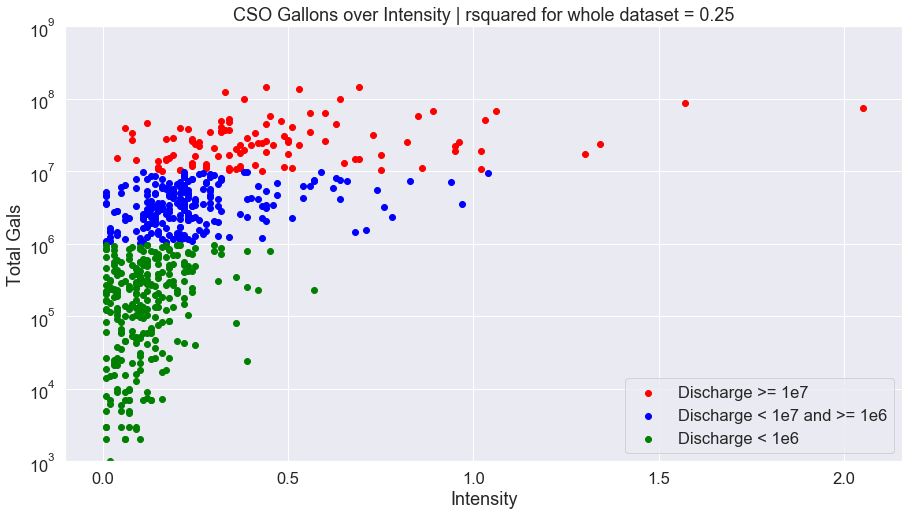

In [796]:
rs = round(np.corrcoef(discharge_df[intensity], discharge_df[discharge])[0,1]**2,2)  # computing the rsquared

fig,ax = plt.subplots()
ax.set(xlabel = 'Intensity', ylabel= 'Total Gals',
           title= 'CSO Gallons over Intensity | rsquared for whole dataset = {}'.format(rs))
ax.grid(True)

plt.scatter(discharge_df_more_1e7[intensity],discharge_df_more_1e7[discharge], c ='red', label = 'Discharge >= 1e7')
plt.scatter(discharge_df_1e6[intensity],discharge_df_1e6[discharge], c ='blue', label = 'Discharge < 1e7 and >= 1e6')
plt.scatter(discharge_df_less_1e6[intensity],discharge_df_less_1e6[discharge], c ='green', label = 'Discharge < 1e6')

plt.ylim(1e3,1e9)
plt.yscale('log')
ax.legend()
plt.show()

### Below: Values < 1e7 and >= 1e6

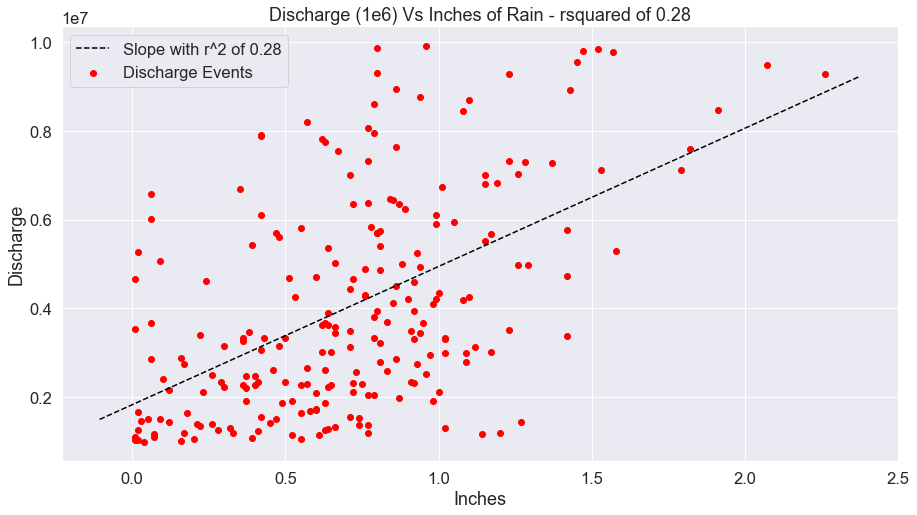

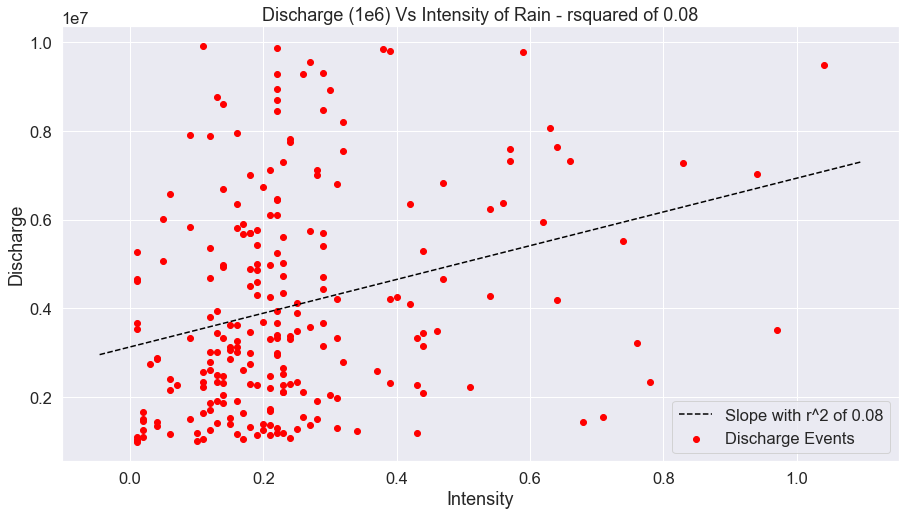

In [797]:
graph_slope_rs(discharge_df_1e6[inches],discharge_df_1e6[discharge],"Inches","Discharge", "Discharge (1e6) Vs Inches of Rain", "Discharge Events", slope_on=True, log=False)
graph_slope_rs(discharge_df_1e6[intensity],discharge_df_1e6[discharge],"Intensity","Discharge", "Discharge (1e6) Vs Intensity of Rain","Discharge Events", slope_on=True, log=False)

### Below: Values < 1e7 and >= 1e6

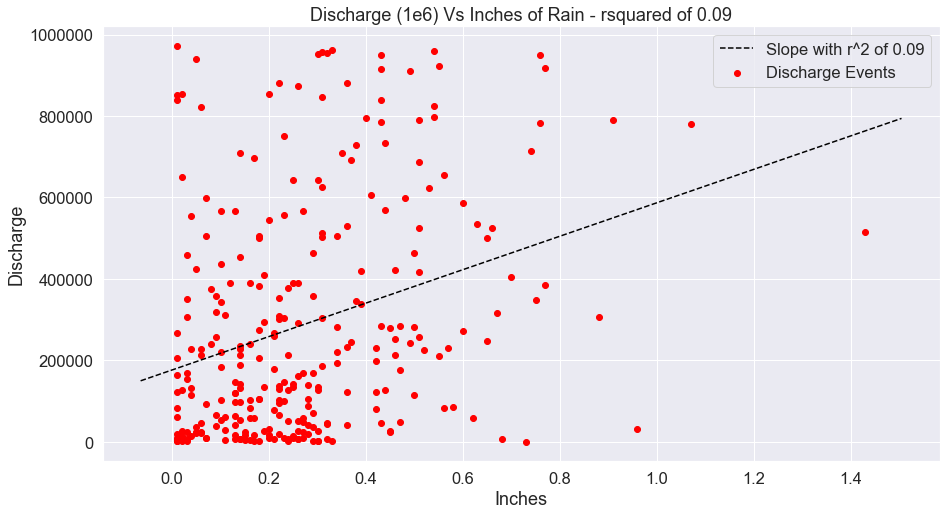

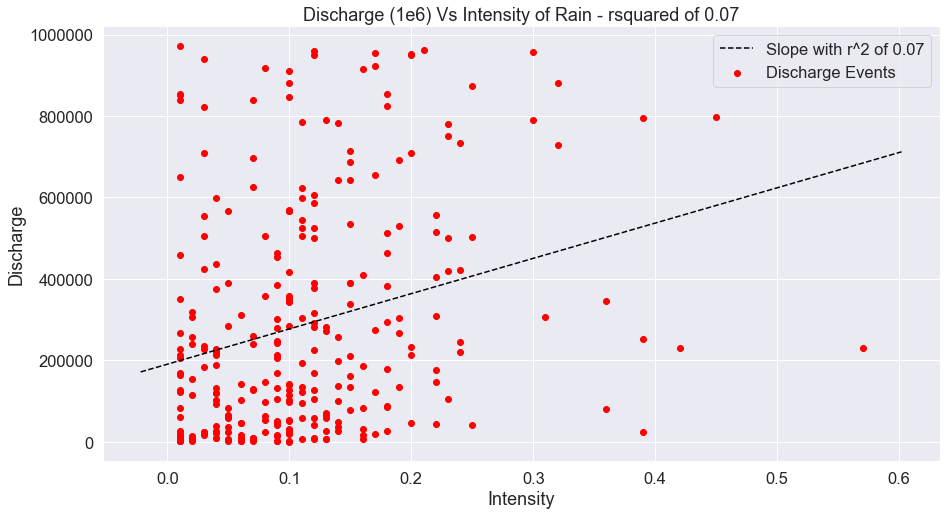

In [799]:
graph_slope_rs(discharge_df_less_1e6[inches],discharge_df_less_1e6[discharge],"Inches","Discharge", "Discharge (1e6) Vs Inches of Rain", "Discharge Events", slope_on=True, log=False)
graph_slope_rs(discharge_df_less_1e6[intensity],discharge_df_less_1e6[discharge],"Intensity","Discharge", "Discharge (1e6) Vs Intensity of Rain","Discharge Events", slope_on=True, log=False)

It becomes immediately apparent that attempting to form a direct linear relationship between discharge and any one variable is fruitless once discharge is plotted against inches and then intensity at values < 1e7 and >= 1e6, and values < 1e6. At this point there would be a better chance of correctly guessing the value by throwing a dart at a dart board.

But hopefully since the model is simply an attempt to predict whether or not a CSO wil occur and in which order of magnitude it will be, a lack of a linear relationship in either of these scenerios may not sink it yet.

_______

Next stage is to use both inches and intensity variables in a regression to try and determine a better model.

In [457]:
y = discharge_df[discharge] 
x = discharge_df[[inches,intensity]]

regr = linear_model.LinearRegression(fit_intercept = False)  # if intercept isnt set to false there are negative values
regr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [803]:
def magnitude(x):
    return int(math.log10(x))

def predict_vals(dataframe_predict, magnitude_text):
    order_mag_y = 0
    order_mag_n = 0
    left_over = 0

    for index, row in dataframe_predict.iterrows():
        prediction = float(''.join(map(str, regr.predict([[row['Inches'],row['Intensity']]]))))
        if prediction >= 0:

            if magnitude(row['Discharge']) == magnitude(pd.to_numeric(''.join(map(str, regr.predict([[row['Inches'],row['Intensity']]]))))):
                order_mag_y += 1
            else:
                order_mag_n += 1

            dataframe_predict.at[index,'Prediction'] = prediction
        else:
            left_over += 1
            dataframe_predict.at[index,'Prediction'] = float(0)
    print('Calculating for {} values.'.format(magnitude_text))
    print('Same order of magnitude:', order_mag_y,'| Incorrect order of magnitude:', order_mag_n, '| Leftover:',left_over)
    percent_correct = order_mag_y/(order_mag_y+order_mag_n+left_over)*100
    print('Percent Correct:',round(percent_correct))
    print()

### Regression All Values

Fitting all of the discharge data to the regression leaves the prediction with 233 values in the same order of magnitude as the actual discharge, 337 outside the order of magnitude, and 43 left over. The left overs are values that the regession set to below zero, and had to be adjusted to 0. With this model the correct values make up 38% of the total prediction.

In [802]:
predict_vals(discharge_df, 'all')

Calculating for all values.
Same order of magnitude: 233 | Incorrect order of magnitude: 337 | Leftover: 43
Percent Correct: 38



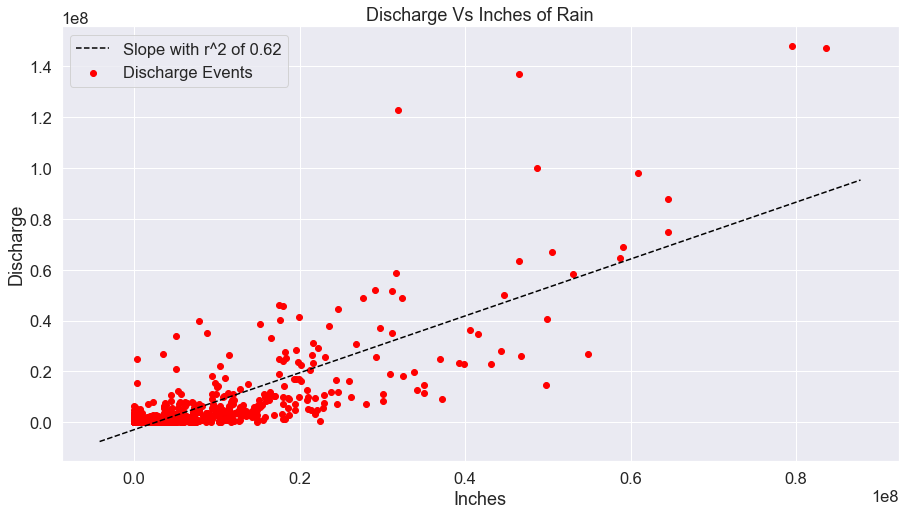

In [597]:
graph_slope_rs(pd.to_numeric(discharge_df['Prediction']),discharge_df[discharge],"Inches","Discharge", "Discharge Vs Inches of Rain", "Discharge Events")

With an rsquared of 0.62, despite missing the correct order of magnitude, the regression model is closer to the mark than the attempts at simply reducing the data to smaller discharge values, as seen in the graph above.

In the graph below the same data is plotted as the graph above, however the x and y axis are set to a log scale to get a better understanding of how the data is distributed. The black line is where we would want our data if the regression model resulted in perfect predictions. Here it can be seen how the model overshoots. Actual values hovering around 1e6 are computed to be around 1e7 by the model. To be more positive about the results, it is better to overshoot a CSO prediciton than undershoot it - at least for the people dealing with the overflows. 

Just by first impressions, it looks like the model actually gets more accurate as the numbers increase, going against the first guess earlier on in the notebook.

In [627]:
def log_plot(dataframe_log, title):
    sns.scatterplot(x = 'Prediction', y = discharge, s = 100, data =dataframe_log, label = 'Events')  # scatter plot with log scale
    plt.xlim(1e2, 1e9)
    plt.xscale('log')
    plt.ylim(1e2, 1e9)
    plt.yscale('log')
    slope, intercept = np.polyfit([1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9], [1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9], 1)  # computing the slope and intercept
    rsquared = round(np.corrcoef([1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9], [1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9])[0,1]**2,2)  # computing the rsquared
    abline(slope,intercept, rsquared)

    ax = plt.gca()
    ax.set(xlabel = 'Predicted Discharge (gal)', ylabel= ' Actual Discharge (gal)',
            title= title)
    ax.grid(True)
    #ax.legend()
    plt.show()

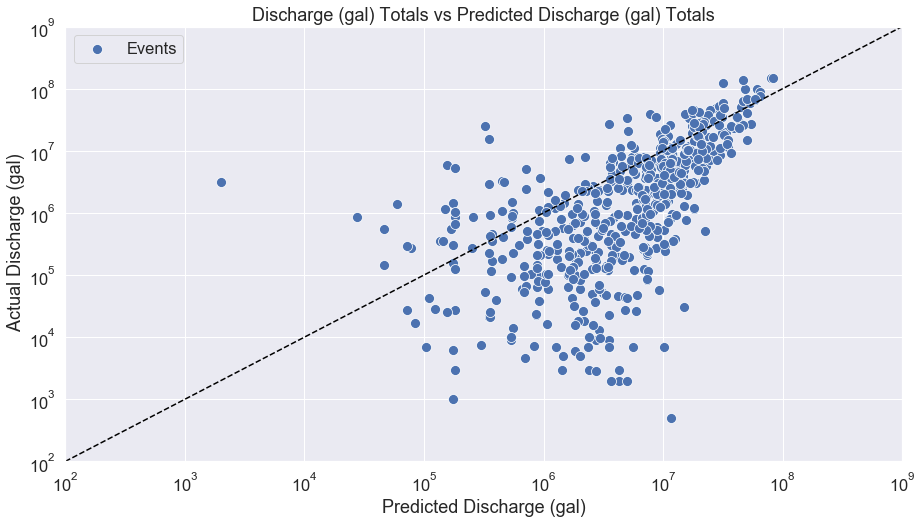

In [628]:
log_plot(discharge_df, 'Discharge (gal) Totals vs Predicted Discharge (gal) Totals')

In [804]:
predict_vals(discharge_df_less_1e6, '<= 1e5')
predict_vals(discharge_df_1e6, '< 1e7 and >= 1e6')
predict_vals(discharge_df_more_1e7, '>= 1e7')

Calculating for <= 1e5 values.
Same order of magnitude: 38 | Incorrect order of magnitude: 214 | Leftover: 30
Percent Correct: 13

Calculating for < 1e7 and >= 1e6 values.
Same order of magnitude: 109 | Incorrect order of magnitude: 104 | Leftover: 13
Percent Correct: 48

Calculating for >= 1e7 values.
Same order of magnitude: 86 | Incorrect order of magnitude: 19 | Leftover: 0
Percent Correct: 82



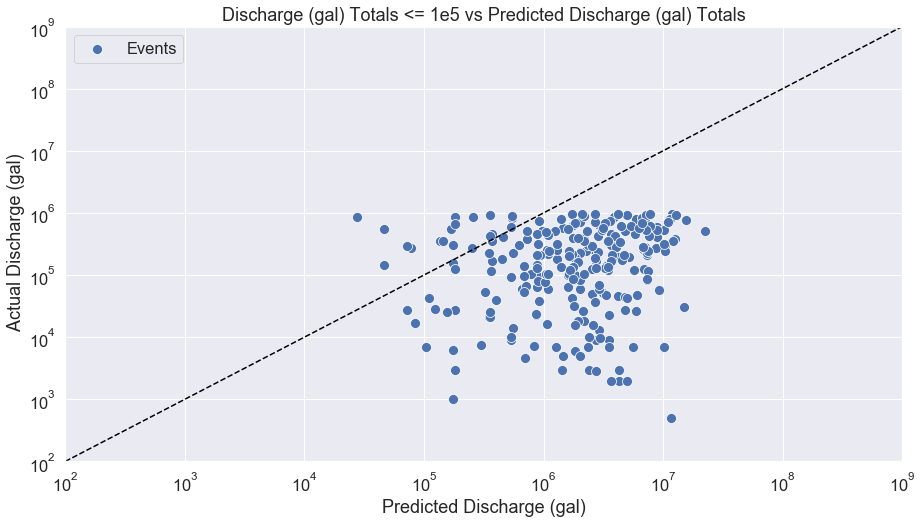

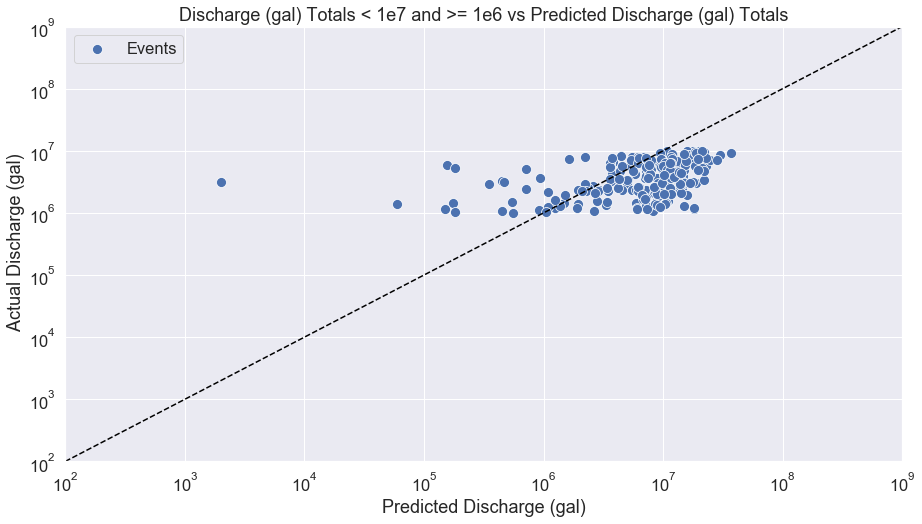

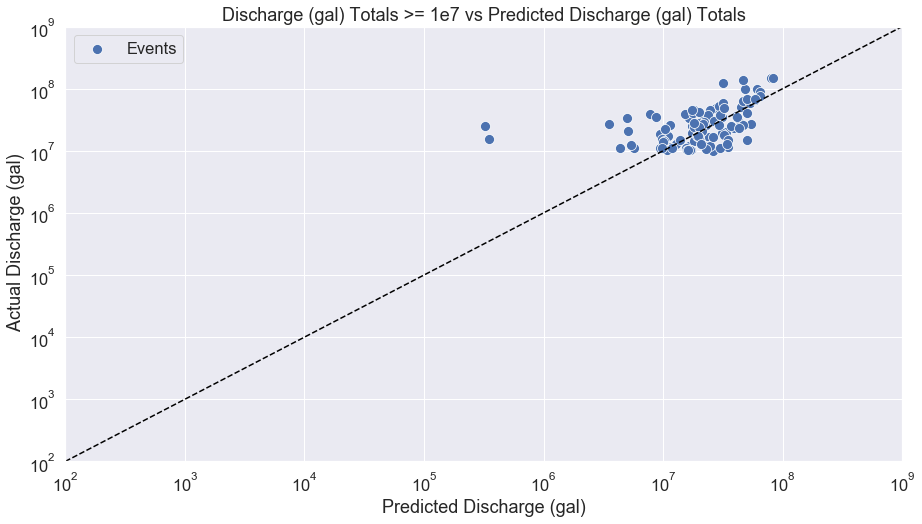

In [806]:
log_plot(discharge_df_less_1e6, 'Discharge (gal) Totals <= 1e5 vs Predicted Discharge (gal) Totals')
log_plot(discharge_df_1e6, 'Discharge (gal) Totals < 1e7 and >= 1e6 vs Predicted Discharge (gal) Totals')
log_plot(discharge_df_more_1e7, 'Discharge (gal) Totals >= 1e7 vs Predicted Discharge (gal) Totals')

The pitfalls of the model at lower values becomes very apparent when examining just the lower discharge values. When the values are <= 1e5 the model overshoots by two orders of magnitude. Values < 1e7 and >= 1e6 are more accurate, with a correctness of 48% and only overshooting by one order of magnitude.

The model does accurately predictt the order of magnitude for 82% of the discharge values when only examining >= 1e7 values. These values make up less than 20% of the dataset, so it is not too helpful to be able to accuraltely guess them, coupled with the fact that sewer separation and storage efforts will continue to decrease the total discharge volume per event.

When combining both break points >= 1e6 the dataset is able to capture 84% of the values, with an accuracy of 59% and only appearing to be off by half a magnitude on the majority of the incorrect values (seen below).

Calculating for >= 1e6 values.
Same order of magnitude: 195 | Incorrect order of magnitude: 123 | Leftover: 13
Percent Correct: 59



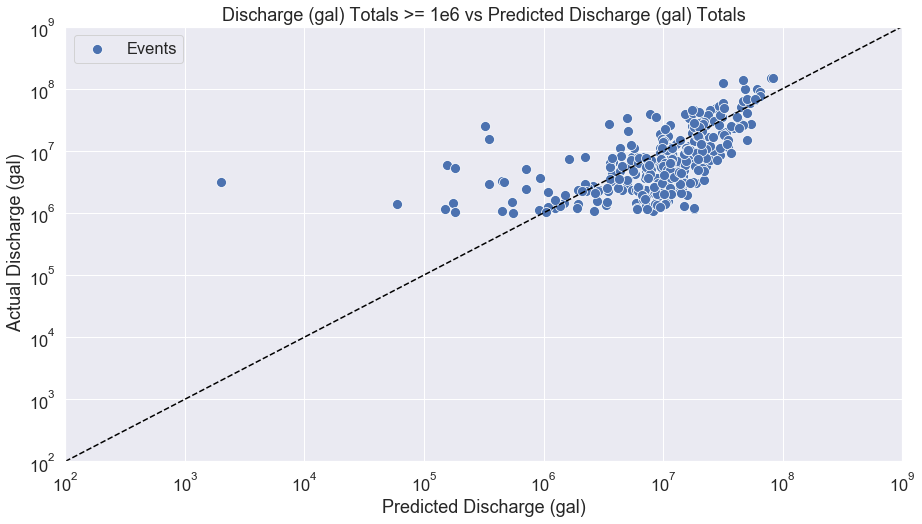

In [807]:
discharge_df_more_1e6 = discharge_df[discharge_df[discharge] >= 1e6]
predict_vals(discharge_df_more_1e6, '>= 1e6')
log_plot(discharge_df_more_1e6, 'Discharge (gal) Totals >= 1e6 vs Predicted Discharge (gal) Totals')

_____